# Python Notebook to demonstrate Vibration Mode Recognition Using A Combination Of DSP And Machine Learning

This program downloads an arbitrary number of .wav file recordings of rotating machines, displaying four different vibration modes, it then uses a subset of data from each file to train a Convolutional Neural Network (CNN) to recognize the different vibration modes then tests the model using a further subset of the data.

.wav file recordings can be downloaded from a website URL (GitHub Raw User Content) or copied from Google Drive /wav_files folder.

Prior to the CNN, the time domain vibration data is converted to the frequency domain. This allows a drastic reduction in the complexity of the CNN.

This file trains and tests the model, it also generates a Tensorflow Lite model, with 8 bit quantization, runs the model on the test sequence and prints the results.

The CNN architecture is shown in the following image. It has 128 input nodes, which are the 128 frequency domain coefficients between D.C. and the Nyquist frequency, for the 256 sample input frame of the time domain sequence. It has an output node for each classification category.

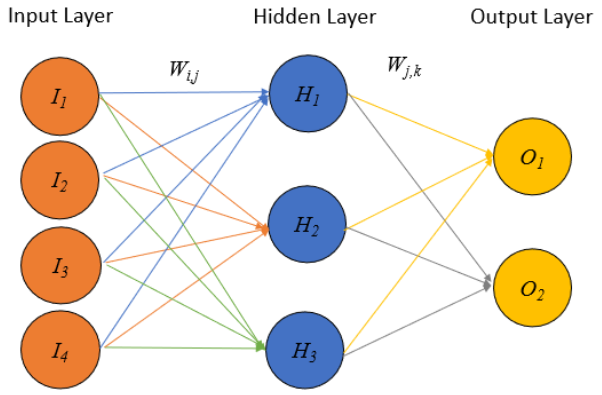

SigLib DSP Library can be downloaded from: https://github.com/Numerix-DSP/siglib

Sigma Numerix Ltd. Machine Learning capabilities are summarized here: https://numerix-dsp.com/ai/

**License**

This program is free software: you can redistribute it and/or modify 
it under the terms of the GNU General Public License as published by 
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.
 
You should have received a copy of the GNU General Public License 
along with this program. If not, see <http://www.gnu.org/licenses/>.

Copyright (c) 2024, Delta Numerix, All rights reserved.


In [60]:
import numpy as np
import tensorflow as tf
import os

from google.colab import drive
from matplotlib import pyplot as plt
from scipy.io import wavfile
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [61]:
# Top level configuration

# .wav file sampling rate = 16 kHz
# Frame size = 256 samples
# Frame period = 16 ms

timeDomainFrameLength = 256
networkInputLayerNodes = timeDomainFrameLength >> 1

# Allow data to be stored in Google Drive or on a website
# Allows working online or, if we have copied the files locally, we can work off-line
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/drive', force_remount=True)
  masterUrlRoot="/content/drive/MyDrive/wav_files/"
else:
  masterUrlRoot = 'https://raw.githubusercontent.com/Numerix-DSP/siglib/main/Examples/CExamples/MachineLearning/sourceData/'

# Input filenames:
wavFilenames = [
  'Machine1.wav',
  'Machine2.wav',
  # 'Machine3.wav',
  # 'Machine4.wav',
]

numClasses = len(wavFilenames)
print (f'numClasses: {numClasses}')


numClasses: 2


In [62]:
# Load .wav files and create a list containing all wav datasets

wavData = []
for i in range(0, numClasses):
  if (os.path.exists(wavFilenames[i]) != True):          # If files are stored locally, we can skip this
    fileurl = masterUrlRoot + wavFilenames[i]
    print(f'Loading fileurl: {fileurl}')
    if 'https://' in fileurl:
      !wget -arg1 $fileurl
    else:
      !cp $fileurl .
  sampleRate, wd = wavfile.read(wavFilenames[i])
  wavData.append(wd)
  print(f'len(wavData{i}): {len(wavData[i])}')
  print(f'Sample Rate: {sampleRate}')


len(wavData0): 3023499
Sample Rate: 16000
len(wavData1): 2852709
Sample Rate: 16000


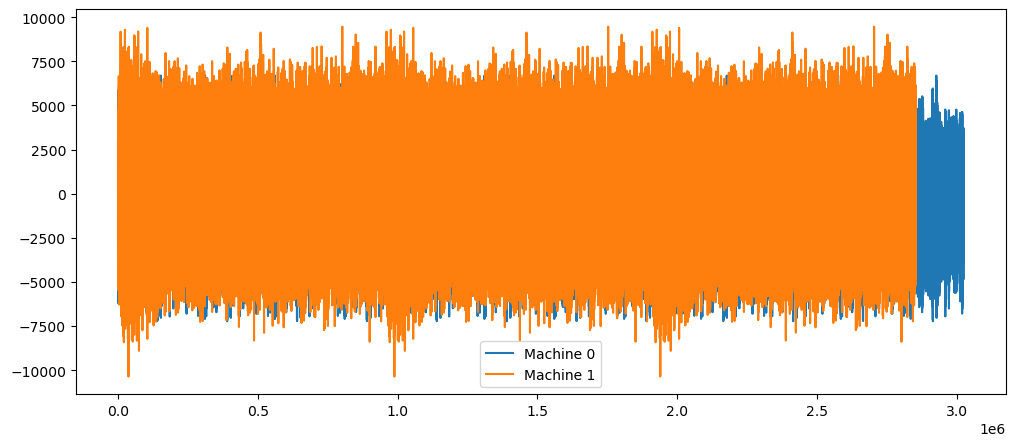

In [63]:
# Plot data to verify it

plt.figure()
for i in range(0, numClasses):
  plt.plot(wavData[i], label=f'Machine {i}')
plt.legend(loc="best")
plt.show()
plt.close()


In [64]:
# Create a list of Numpy 2D arrays from waveforms
# Limit the dataset lengths to modulo timeDomainFrameLength

wav_2D_list = []
for i in range(0, numClasses):
  maxIndex = (len(wavData[i])//timeDomainFrameLength)*timeDomainFrameLength
  wavData[i] = wavData[i][:maxIndex]
  wav_2D_list.append(np.reshape(wavData[i], (-1, timeDomainFrameLength)))
  print(f'wav_2D_list[{i}] shape: {wav_2D_list[i].shape}')

# print(wav_2D_list)


wav_2D_list[0] shape: (11810, 256)
wav_2D_list[1] shape: (11143, 256)


In [65]:
# Perform DSP Pre-processing on subframes
# Pre-process function for translating data from time to frequency domain
# This function processes a single waveform, which is a 2D Numpy array, with each row being the FFT length
def pre_process(wav_2D_array):
  window = np.blackman(timeDomainFrameLength)

              # Create empty frequency domain Numpy array
  wav_fftd_2D_array = np.empty(shape=[0, networkInputLayerNodes])

  # print(len(wav_2D_array))
  for i in range(len(wav_2D_array)):
    windowed = wav_2D_array[i] * window

            # Real to Real FFT and normalize for FFT scaling
    fftd = np.fft.fft(windowed, timeDomainFrameLength) / (timeDomainFrameLength/2.0)
    fftd = np.abs(fftd.real)

            # Truncate output to only include selected frequency domain coefficients from D.C. to Nyquist frequency
    fftd = fftd[0:networkInputLayerNodes]
    wav_fftd_2D_array = np.append(wav_fftd_2D_array, np.reshape(fftd, (-1, networkInputLayerNodes)), axis=0)
  return (wav_fftd_2D_array)


In [66]:
# Process each dataset from the list individually - each dataset in the list is a 2D Numpy array, with each row being the FFT length
wav_fftd_2D_list = []
for i in range(0, numClasses):
  wav_fftd_2D_list.append(pre_process (wav_2D_list[i]))
  print(f'wav_fftd_2D_list[{i}] shape: {wav_fftd_2D_list[i].shape}')


wav_fftd_2D_list[0] shape: (11810, 128)
wav_fftd_2D_list[1] shape: (11143, 128)


In [67]:
# Split into training/validation (90%) and testing (10%) datasets

def split_array_train_test(wav_array, train_percentage):
  train_len = (len(wav_array) * (train_percentage)) // 100
  return wav_array[:train_len], wav_array[train_len:]

wav_xtrain = []
wav_xtest = []
for i in range(0, numClasses):
  wr, wt = split_array_train_test (wav_fftd_2D_list[i], 90)
  wav_xtrain.append(wr)
  wav_xtest.append(wt)

  print(f'wav{i} # subframes: {len(wav_fftd_2D_list[i])}')
  print(f'wav{i} train shape: {wav_xtrain[i].shape}')
  print(f'wav{i} test shape: {wav_xtest[i].shape}')


wav0 # subframes: 11810
wav0 train shape: (10629, 128)
wav0 test shape: (1181, 128)
wav1 # subframes: 11143
wav1 train shape: (10028, 128)
wav1 test shape: (1115, 128)


In [68]:
# Create X and Y datasets for training, testing and validation

X_train = wav_xtrain[0]
X_test = wav_xtest[0]
for i in range(1, numClasses):
  X_train = np.concatenate((X_train, wav_xtrain[i]), axis=0)
  X_test = np.concatenate((X_test, wav_xtest[i]), axis=0)

# Create labels
wav_ytrain = []
wav_ytest = []
for i in range(0, numClasses):
  wav_ytrain.append(np.full(len(wav_xtrain[i]), i))
  wav_ytest.append(np.full(len(wav_xtest[i]), i))

y_train = wav_ytrain[0]
y_test = wav_ytest[0]
for i in range(1, numClasses):
  y_train = np.concatenate((y_train, wav_ytrain[i]), axis=0)
  y_test = np.concatenate((y_test, wav_ytest[i]), axis=0)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (20657, 128)
y_train shape: (20657,)
X_test shape: (2296, 128)
y_test shape: (2296,)


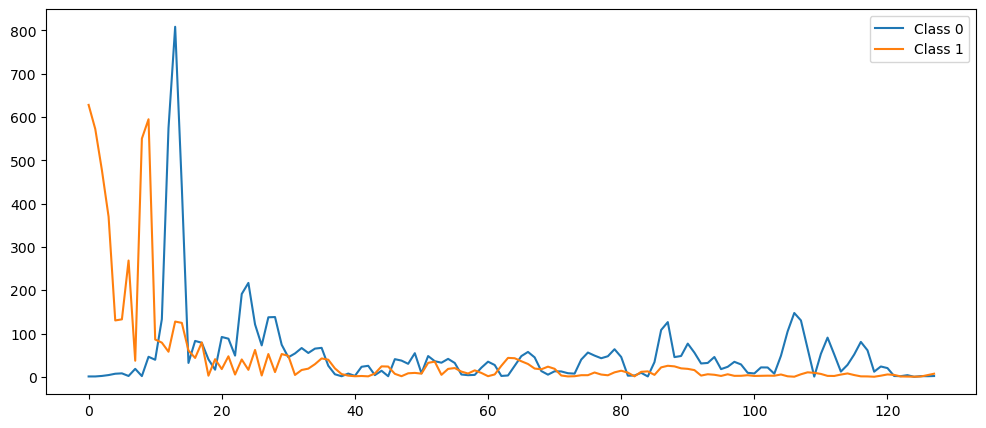

In [69]:
# Plot an arbitrary frame (100) of each class
# Don't plot first frame because there may be some zero padding in the source file

plt.figure()
for c in range(numClasses):
  c_X_train = X_train[y_train == c]
  plt.plot(c_X_train[100], label="Class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


In [70]:
# Reshape for Keras

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (20657, 128, 1)
X_test shape: (2296, 128, 1)


In [71]:
# Time Series Classification Model
input_layer = tf.keras.layers.Input(shape=(networkInputLayerNodes,1))
conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=networkInputLayerNodes, activation='relu', use_bias=True)(input_layer)
output_layer = tf.keras.layers.Dense(numClasses, activation="sigmoid", use_bias=True)(conv1)

model_tsc = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model_tsc.summary()
tf.keras.utils.plot_model(model_tsc, show_shapes=True)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 dense_3 (Dense)             (None, 1, 2)              66        
                                                                 
Total params: 4,194
Trainable params: 4,194
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [72]:
# Train the model

callbacks = [
  tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
]
model_tsc.compile(
  optimizer="adam",
  loss="sparse_categorical_crossentropy",
  metrics=["sparse_categorical_accuracy"])
history = model_tsc.fit(
  X_train,
  y_train,
  batch_size=32,
  epochs=4,
  shuffle=True,
  callbacks=callbacks,
  validation_split=0.2,
  verbose=1)


Epoch 1/4
517/517 [==============================] - 2s 2ms/step - loss: 0.0239 - sparse_categorical_accuracy: 0.5559 - val_loss: 0.0051 - val_sparse_categorical_accuracy: 0.9993
Epoch 2/4
517/517 [==============================] - 1s 2ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.5548 - val_loss: 3.2312e-09 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/4
517/517 [==============================] - 1s 2ms/step - loss: 0.0018 - sparse_categorical_accuracy: 0.5558 - val_loss: 2.8850e-11 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/4
517/517 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.5560 - val_loss: 2.8850e-11 - val_sparse_categorical_accuracy: 1.0000


In [73]:
# Test the model

model_tsc = tf.keras.models.load_model("best_model.h5")
test_loss, test_acc = model_tsc.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss:     {test_loss}')


72/72 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9976
Test accuracy: 0.9976255297660828
Test loss:     0.0


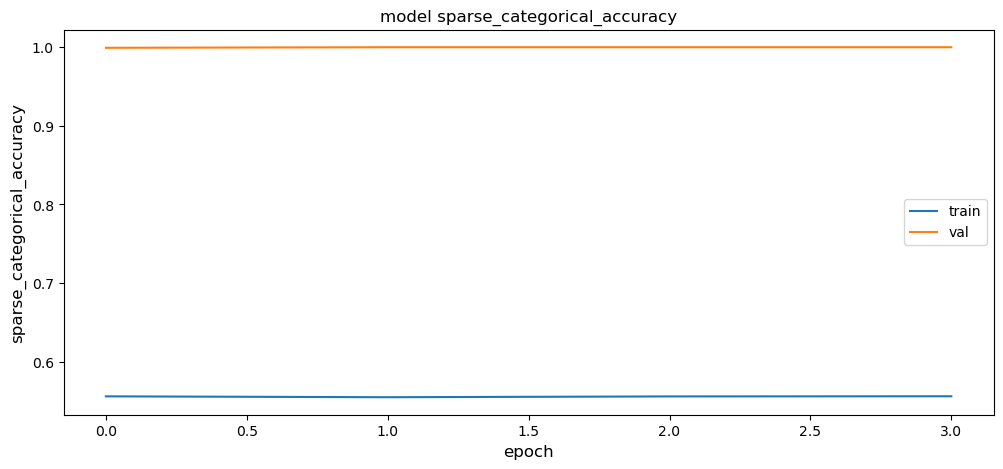

In [74]:
# Plot the accuracy as the CNN trains

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.rcParams["figure.figsize"] = 12,5
plt.show()
plt.close()


72/72 [==============================] - 0s 1ms/step
y_pred shape: (2296, 1, 2)
y_test shape: (2296,)
y_pred shape: (2296, 1)


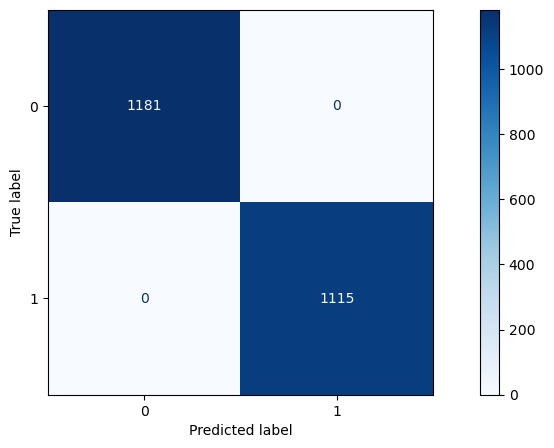

In [75]:
# Generate a confusion matrix to see which classes perform well or poorly
y_pred = model_tsc.predict(X_test)          # Returns probabilities

print(f'y_pred shape: {y_pred.shape}')

y_pred = np.argmax(y_pred, axis=-1)         # Return the index of the prediction with highest probability
print(f'y_test shape: {y_test.shape}')
print(f'y_pred shape: {y_pred.shape}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.rcParams["figure.figsize"] = 12,5
plt.show()


In [76]:
# Convert to a Tensorflow Lite model for deployment on a microcontroller

converter = tf.lite.TFLiteConverter.from_keras_model(model_tsc)
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS ]       # enable TensorFlow Lite ops.
tflite_model = converter.convert()
open("tsc.tflite", "wb").write(tflite_model)


2024-02-19 00:05:57.313542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,32]
	 [[{{node inputs}}]]
2024-02-19 00:05:57.421598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmp_b4ld7nj/assets


INFO:tensorflow:Assets written to: /tmp/tmp_b4ld7nj/assets
2024-02-19 00:05:57.782338: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-19 00:05:57.782378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-19 00:05:57.782527: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_b4ld7nj
2024-02-19 00:05:57.783134: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-19 00:05:57.783144: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_b4ld7nj
2024-02-19 00:05:57.785724: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-19 00:05:57.807023: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp_b4ld7nj
2024-02-19 00:05:57.813505: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

21188

In [77]:
# Generate a quantized Tensorflow Lite model

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_tsc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]     # If any ops can't be quantized the converter throws an error
converter.inference_input_type = tf.uint8           # Input and output tensor format
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
open("tsc_quant.tflite", "wb").write(tflite_model_quant)


2024-02-19 00:05:58.006960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,32]
	 [[{{node inputs}}]]
2024-02-19 00:05:58.092755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmpq27wsnyn/assets


INFO:tensorflow:Assets written to: /tmp/tmpq27wsnyn/assets
/home/johne/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-02-19 00:05:58.747278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-19 00:05:58.747328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-19 00:05:58.747468: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq27wsnyn
2024-02-19 00:05:58.748461: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-19 00:05:58.748482: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq27wsnyn
2024-02-19 00:05:58.753124: I tensorflow/cc/saved_model/loader.

10280

In [78]:
interpreter = tf.lite.Interpreter(model_path="tsc_quant.tflite")    # Load tensorflow lite model
interpreter.allocate_tensors()                      # Allocate tensors

input_details = interpreter.get_input_details()     # Get input and output tensor details
output_details = interpreter.get_output_details()

error_count = 0
num_test_sequences = X_test.shape[0]
print(f'num_test_sequences: {num_test_sequences}')
print(f'Max: {np.amax(X_test)}')
print(f'Min: {np.amin(X_test)}')

for i in range(0, num_test_sequences):
  X_temp=X_test[i].reshape(1, 128, 1) / 10.       # Reshape each frame for interpreting and scale for 8 bit
  input_data = np.array(X_temp, dtype=np.uint8)
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  output_data = interpreter.get_tensor(output_details[0]['index'])    # Return a copy of the tensor data
  maxIndex = np.argmax(output_data)              # Get category with highest probability
  if (maxIndex != y_test[i]):
      error_count += 1

print(f'error_count:   {error_count}')
print(f'Test accuracy: {(num_test_sequences-error_count)*100./num_test_sequences}')
print(f'Test loss:     {(error_count)*100./num_test_sequences}')


num_test_sequences: 2296
Max: 1869.3379764699184
Min: 4.759140239229964e-05
error_count:   0
Test accuracy: 100.0
Test loss:     0.0
